This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [198]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

**Answer** 



$$ 
\hat{a}(\nu_x,\nu_y) = \sum_{n=-\infty}^{+\infty} \sum_{m=-\infty}^{+\infty} a(n,m) e^{-i2\pi (\nu_x n+\nu_y m)} 
$$



Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Answer**
$$
\hat{b}(\nu_x,\nu_y) = \sum_{n=-\infty}^{+\infty} \sum_{m=-\infty}^{+\infty} b(n,m) e^{-i2\pi (\nu_x n+\nu_y m)} 
= \sum_{n=-\infty}^{+\infty} \sum_{m=-\infty}^{+\infty} a(n+c,m+c) e^{-i2\pi (\nu_x (n+c)+\nu_y (m+c))} e^{+i2\pi (\nu_xc+\nu_yd)} 
= \sum_{n=-\infty}^{+\infty} \sum_{m=-\infty}^{+\infty} a(n,m) e^{-i2\pi (\nu_x n+\nu_y m)} e^{+i2\pi (\nu_xc+\nu_yd)} 
$$
$$
\hat{b}(\nu_x,\nu_y)=\hat{a}(\nu_x,\nu_y) e^{+i2\pi (\nu_xc+\nu_yd)}

$$

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Answer**

We have: 
$$
\hat{b}(\nu_x,\nu_y)=\hat{a}(\nu_x,\nu_y) e^{i2\pi (c\nu_x+d\nu_y)}
$$

$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \frac{\hat{a}(\nu_x,\nu_y)e^{+i2\pi (c\nu_x+d\nu_x)}}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Answer**

$$
 \hat{A}(k_x,k_y)= \sum_{n=0}^{N} \sum_{m=0}^{N} a(n,m) e^{\frac{2i\pi (k_x n+k_ym)}{N}} 
 $$

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

**Answer**

If:
 - $b$ is a translation of $a$.
 - $b$ and $a$ are N-periodic.

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [199]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

im1l = loadmat('lena.mat')['im1']
im1l = im1l.astype('float')

N, M = np.shape(im1)
Nl, Ml = np.shape(im1l)
#plt.figure(),plt.imshow(im1,cmap='gray')


Text(0.5, 1.0, 'Lena image')

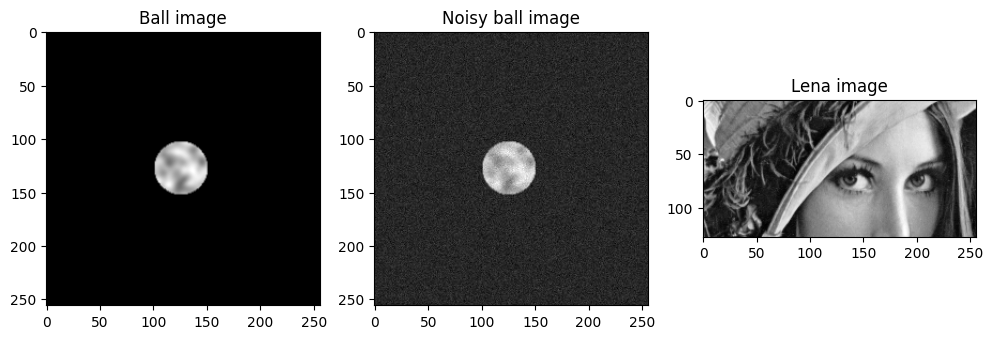

In [200]:
# Potentially add noise to the image
sigma = 10
im1b = im1 + sigma*np.random.randn(N,M)
#plt.figure(),plt.imshow(im1,cmap='gray')

plt.figure(figsize=(12,12))
plt.subplot(2, 3, 1)
plt.imshow(im1, cmap='gray')
plt.title('Ball image')

plt.subplot(2,3,2)
plt.imshow(im1b, cmap='gray')
plt.title('Noisy ball image')

plt.subplot(2,3,3)
plt.imshow(im1l, cmap='gray')
plt.title('Lena image')





In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [201]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

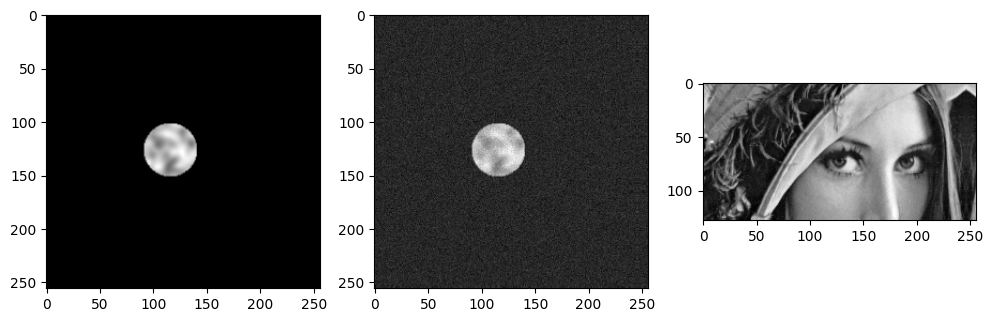

In [202]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b,out=20)
#plt.figure(),plt.imshow(im2,cmap='gray')

im2b = applyAffineMotion(im1b, b, out=20)
im2l = applyAffineMotion(im1l,b,out=20)

plt.figure(figsize=(12,12))
plt.subplot(2, 3, 1)
plt.imshow(im2, cmap='gray')

plt.subplot(2,3,2)
plt.imshow(im2b, cmap='gray')

plt.subplot(2,3,3)
plt.imshow(im2l, cmap='gray')


Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:** We can use the quotient of the two FFTS to access the parameters of the translation. Indeed the quotient is a linear phase signal equal to :
$$ \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right) $$

We can then compute the phase of the signal and access the translation parameters c and d.

In [203]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

IM1B = np.fft.fft2(im1b)
IM2B = np.fft.fft2(im2b)

IM1L = np.fft.fft2(im1l)
IM2L = np.fft.fft2(im2l)

Compute the phase of the Fourier transform.

In [204]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [205]:
phi = angle2D(IM1/IM2)
phiB = angle2D(IM1B/IM2B)
phiL = angle2D(IM1L/IM2L)


Display phi. Is it a linear plane and why?

Text(0.5, 0.92, 'Lena image')

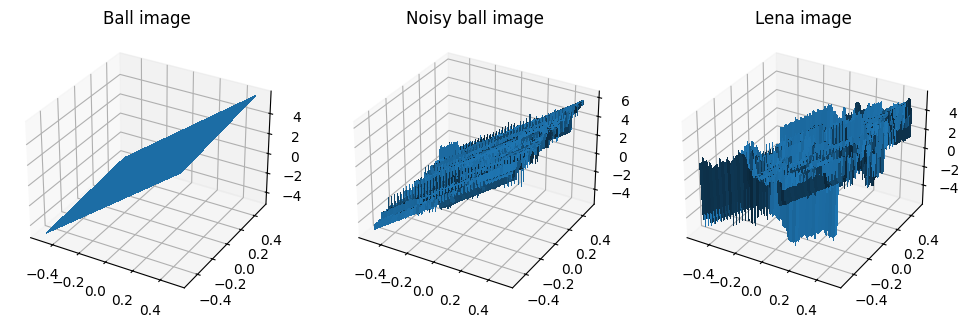

In [206]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fxb, fyb = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fxl, fyl = np.meshgrid(np.arange(-(Ml-1)/2,(Ml-1)/2+1)/Ml, np.arange(-(Nl-1)/2,(Nl-1)/2+1)/Nl)


fig, ax = plt.subplots(1, 3, figsize=(12, 12), subplot_kw={"projection": "3d"})

surf = ax[0].plot_surface(fx, fy, phi, linewidth=0, antialiased=False)
ax[0].set_title('Ball image')

surf = ax[1].plot_surface(fxb, fyb, phiB, linewidth=0, antialiased=False)
ax[1].set_title('Noisy ball image')

surf = ax[2].plot_surface(fxl, fyl, phiL, linewidth=0, antialiased=False)
ax[2].set_title('Lena image')




**Answer**

Phi is a linear plane only for the Ball image with no noise. It is a simple image with many uniform zone, therefore we verify the hypothesis to have a signal with linear phase for the ratio of the two FFT. It is easier to estimate the translation parameters.

For the Ball image with noise, the result for PHi is not smooth and there are outliers. It is even worse with the Lena image. Indeed, the Lena image is much more complex than the Ball one: there is no periodicity, the shapes are complex...

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [207]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    
    gx = (M[:,1:]-M[:,:-1])/stepX
    gy = (M[1:,:]-M[:-1,:])/stepY
    
    return gx,gy

In [208]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

gxb, gyb = gradient(phiB, 1/M, 1/N)
GXb = np.median(gxb)
GYb = np.median(gyb)

gxl, gyl = gradient(phiL, 1/Ml, 1/Nl)
GXl = np.median(gxl)
GYl = np.median(gyl)



In [209]:
# Ball image
print("Results with the Ball image" )
print(GX)
print(GY)

print("Results with the noisy Ball image" )
print(GXb)
print(GYb)

print("Results with the Lena image" )
print(GXl)
print(GYl)

Results with the Ball image
10.0
1.0
Results with the noisy Ball image
9.96582726217806
0.5068831515626471
Results with the Lena image
9.034491454891963
-0.374093473037739


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Answer** 
- The 2nd method starts by substracting the center of phi to only focus on the slope.
- Then a median filter is applied to remove any noise.
- We construct the regression matrix A which contains the coordinate fx and fy of phi. 
The goal of the method is to estimate phi as: $$ \phi = af_x + bf_y $$ ie $$\phi = A [a, b]^T$$ and to find the parameters a and b.

- By using np.linalg.pinv(A), the method computes the (Moore-Penrose) pseudo-inverse of A (least square approximation): 

- Finally it computes the best estimated translation parameters: 
$$ [a, b] =  A^{+}\phi$$ 



In [210]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [211]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

phiB = phiB-phiB[int(N/2+2), int(M/2+2)]
tB = medianFilter(phiB,1)
AB = np.zeros((np.shape(fxb)[0]*np.shape(fxb)[1],2))
AB[:,0] = fxb.reshape(np.shape(fxb)[0]*np.shape(fxb)[1])
AB[:,1] = fyb.reshape(np.shape(fyb)[0]*np.shape(fyb)[1])
bb = tB.reshape(np.shape(tB)[0]*np.shape(tB)[1])
bEstB = np.dot(np.linalg.pinv(AB),bb)

phiL = phiL-phiL[int(Nl/2+2), int(Ml/2+2)]
tl = medianFilter(phiL,1)
AL = np.zeros((np.shape(fxl)[0]*np.shape(fxl)[1],2))
AL[:,0] = fxl.reshape(np.shape(fxl)[0]*np.shape(fxl)[1])
AL[:,1] = fyl.reshape(np.shape(fyl)[0]*np.shape(fyl)[1])
bl = tl.reshape(np.shape(tl)[0]*np.shape(tl)[1])
bEstL = np.dot(np.linalg.pinv(AL),bl)

In [212]:
print("Results with the Ball image")
print(bEst)
print("Results with the noisy Ball image")
print(bEstB)
print("Results with the Lena image")
print(bEstL)

Results with the Ball image
[9.99981832 0.99999929]
Results with the noisy Ball image
[9.63968583 1.02600174]
Results with the Lena image
[7.90761829 0.01702052]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer**

- With the ball image and no noise I am able to correctly estimate the translation with both methods. Indeed we just saw that phi is a linear plane for this simple image.

- With the noisy ball image ($\sigma=5$) the results obtained are not very satisfying. This is due to the unsmoothness of phi in that case since the noise complexify the image and have less uniform zones. With the second method the results are a bit better, since a median filter is used to get rid of the noise.

- With the Lena image, the estimated translation parameters are not satisfying at all. The image is way more complex, there is no periodicity, less uniform zones, more details and we saw by plotting phi that it is not smooth. There is no clear "slope", making it hard to estimate the translation parameters.


# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [218]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        print("Non-regularized search")
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block
                #print("B shape:",B.shape)
                #print(B)

                # Initialization:
                
                costMin = np.inf
                
                Rbest = ref[r:r+brow,c:c+bcol] # Initialisation of the best block
                row_best_disp = 0
                col_best_disp = 0
                # Loop on candidate displacement vectors
                
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# rcol = candidate displacement vector over the rows
                        im_test = ref_extended[r+drow+extension:r+drow+extension+brow,dcol+extension+c:c+dcol+extension+bcol] # Block in the reference image
                        #print(drow+extension,dcol+extension)
                        #print("drow,dcol:",drow,dcol)
                        #print("im shape:",im_test.shape)
                        #print(im_test)
                        SSD = np.sum((B-im_test)**2) # Sum of squared differences
                        #print("SSD:",SSD)
                        
                        if SSD<costMin: # Save the results if they are better than the previous ones
                            costMin = SSD
                            Rbest = im_test
                            row_best_disp = drow
                            col_best_disp = dcol
                            
                mvf[r:r+brow,c:c+bcol,0] = np.ones((brow,bcol))*row_best_disp # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = np.ones((brow,bcol))*col_best_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                    
    else: # Regularized search
        print("Regularized search")
        for r in range(0, cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1],bcol):
                # current block selection
                B =  cur[r:r+brow, c:c+bcol]# Block

                # Initializations          
                vect = initVector(ref,cur)
                costMin = np.inf
                Rbest = ref[r:r+brow,c:c+bcol] # Initialisation of the best block
                row_best_disp = 0
                col_best_disp = 0

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-extension, extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension, extension): # rcol = candidate displacement vector over the rows
                        im_test = ref_extended[r+drow+extension:r+drow+extension+brow,dcol+extension+c:c+dcol+extension+bcol]
                        vect_test = np.array([drow,dcol])
                        error = np.sum((vect_test - pV)**2)
                        SSD = np.sum((B-im_test)**2)
                        cost = SSD + lamb*error # here, encore the REGULARIZED cost function
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = im_test
                            row_best_disp = drow
                            col_best_disp = dcol
                
                
                mvf[r:r+brow,c:c+bcol,0]= np.ones((brow,bcol))*row_best_disp # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= np.ones((brow,bcol))*col_best_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return



Non-regularized search
5.0
2.0


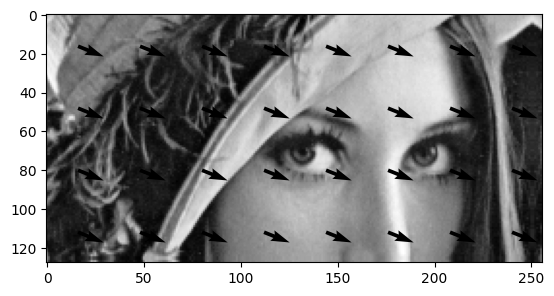

In [234]:
lamb = 0
b = np.array([5,2])
im1= loadmat('lena.mat')['im1']
im1 = im1.astype('float')
im2 = applyAffineMotion(im1,b,out=20)

mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
mvf = -mvf
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [241]:


def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u,kernel_1,'same')
        vAvg= convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx + vAvg*fy + ft)/(alpha**2 + np.linalg.norm(fx+fy+ft)**2)
        v = vAvg - fy*(uAvg*fx + vAvg*fy + ft)/(alpha**2 + np.linalg.norm(fx+fy+ft)**2)     
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

4.988245683181615
1.9955593198255106


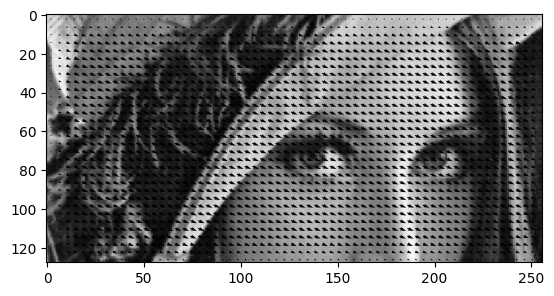

In [242]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Non-regularized search
Results for noisy Lena image with block matching
5.0
2.0
Results for noisy Lena image with optic flow
4.988250188064631
1.9955644601296738


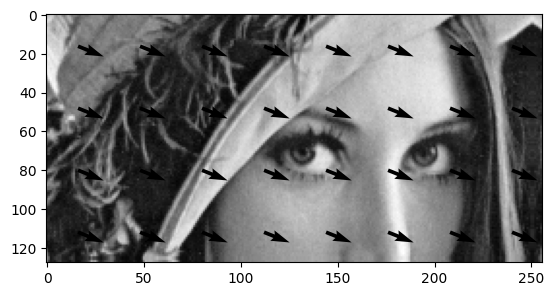

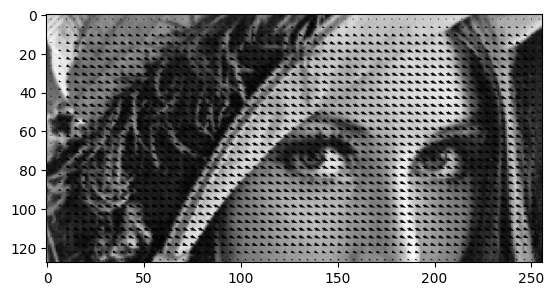

In [243]:
# with noise:
sigma = 2
im1= loadmat('lena.mat')['im1']
im1 = im1 + sigma*np.random.randn(Nl,Ml)
# block matching
lamb = 0
b = np.array([5,2])
im1 = im1.astype('float')
im2 = applyAffineMotion(im1,b,out=20)

mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
mvf = -mvf

print("Results for noisy Lena image with block matching")
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)


print(bx)
print(by)

# Optic Flow

alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
print("Results for noisy Lena image with optic flow")
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)




**Answer**

With the block-matching (ssd) method and optic flow, we are able to estimate the correct translation parameters with and without noise for the Lena image.
The optic flow method is slighly less precise ( we get 4.98 and 1.99 instead of 5 and 2 for instance).

Results for Lena image with block matching with non intergers parameters
Non-regularized search
6.0
2.0
Results for Lena image with optic flow with non intergers parameters
5.282073806336179
2.188466597844868


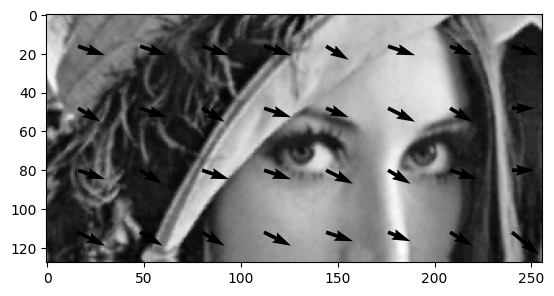

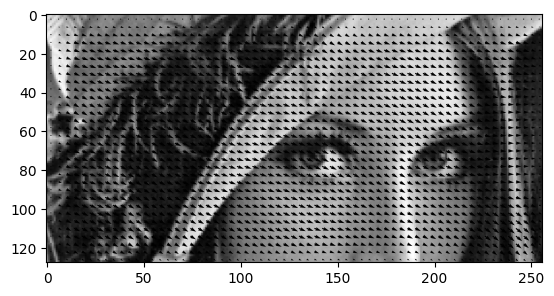

In [244]:
# With non-integer parameter:

#Block matching
print("Results for Lena image with block matching with non intergers parameters")
b= np.array([5.5,2.5])
im1= loadmat('lena.mat')['im1']
im1 = im1.astype('float')
im2 = applyAffineMotion(im1,b,out=20)
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
mvf = -mvf
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

#Optic Flow
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
print("Results for Lena image with optic flow with non intergers parameters")
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)



**Answer**

- The Block-matching algorithm implemented in the first tp works by looking at whole pixels. So if the translation is in between pixels, the results obtained for the translation parameters won't be precise: it rounds the parameters to the nearest integers. This is what we get here.

- The results obtained with the Optic flow method on non-nteger parameters are less precise than when we were estimating integer parameters.